In [1]:
print('hello')

hello


In [2]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.datasets import load_wine
from sklearn.model_selection import StratifiedKFold,cross_validate
from sklearn.metrics import accuracy_score,precision_score,recall_score,mean_absolute_error,mean_squared_error,r2_score,make_scorer
from abc import ABC,abstractmethod
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [3]:
boston = "http://lib.stat.cmu.edu/datasets/boston"
load_boston = pd.read_csv(boston, sep=r"\s+", skiprows=22, header=None)
data = np.hstack([load_boston.values[::2, :], load_boston.values[1::2, :2]])
target = load_boston.values[1::2, 2]

In [4]:
import pandas as pd
import numpy as np

# Load the data
boston = "http://lib.stat.cmu.edu/datasets/boston"
load_boston = pd.read_csv(boston, sep=r"\s+", skiprows=22, header=None)
data = np.hstack([load_boston.values[::2, :], load_boston.values[1::2, :2]])
target = load_boston.values[1::2, 2]

# Create column names
column_names = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 
    'PTRATIO', 'B', 'LSTAT', 'MEDV'
]

# Create the DataFrame
df = pd.DataFrame(data, columns=column_names[:-1])
df['MEDV'] = target

# Save the DataFrame to a CSV file
df.to_csv('boston_housing_data.csv', index=False)

print(df.head())
print("\nDataFrame shape:", df.shape)
print("\nCSV file 'boston_housing_data.csv' has been created.")

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  

DataFrame shape: (506, 14)

CSV file 'boston_housing_data.csv' has been created.


In [5]:
class RandomForest(ABC):
    #initializer
    def __init__(self,n_trees=100):
        self.n_trees = n_trees
        self.trees   = []
    #private function to make bootstrap samples
    def __make_bootstraps(self,data):
        #initialize output dictionary & unique value count
        dc   = {}
        unip = 0
        #get sample size
        b_size = data.shape[0]
        #get list of row indexes
        idx = [i for i in range(b_size)]
        #loop through the required number of bootstraps
        for b in range(self.n_trees):
            #obtain boostrap samples with replacement
            sidx   = np.random.choice(idx,replace=True,size=b_size)
            b_samp = data[sidx,:]
            #compute number of unique values contained in the bootstrap sample
            unip  += len(set(sidx))
            #obtain out-of-bag samples for the current b
            oidx   = list(set(idx) - set(sidx))
            o_samp = np.array([])
            if oidx:
                o_samp = data[oidx,:]
            #store results
            dc['boot_'+str(b)] = {'boot':b_samp,'test':o_samp}
        #return the bootstrap results
        return(dc)

    #public function to return model parameters
    def get_params(self, deep = False):
        return {'n_trees':self.n_trees}

    #protected function to obtain the right decision tree
    @abstractmethod
    def _make_tree_model(self):
        pass
    
    #protected function to train the ensemble
    def _train(self,X_train,y_train):
        #package the input data
        training_data = np.concatenate((X_train,y_train.reshape(-1,1)),axis=1)
        #make bootstrap samples
        dcBoot = self.__make_bootstraps(training_data)
        #iterate through each bootstrap sample & fit a model ##
        tree_m = self._make_tree_model()
        dcOob    = {}
        for b in dcBoot:
            #make a clone of the model
            model = clone(tree_m)
            #fit a decision tree model to the current sample
            model.fit(dcBoot[b]['boot'][:,:-1],dcBoot[b]['boot'][:,-1].reshape(-1, 1))
            #append the fitted model
            self.trees.append(model)
            #store the out-of-bag test set for the current bootstrap
            if dcBoot[b]['test'].size:
                dcOob[b] = dcBoot[b]['test']
            else:
                dcOob[b] = np.array([])
        #return the oob data set
        return(dcOob)
      
    #protected function to predict from the ensemble
    def _predict(self,X):
        #check we've fit the ensemble
        if not self.trees:
            print('You must train the ensemble before making predictions!')
            return(None)
        #loop through each fitted model
        predictions = []
        for m in self.trees:
            #make predictions on the input X
            yp = m.predict(X)
            #append predictions to storage list
            predictions.append(yp.reshape(-1,1))
        #compute the ensemble prediction
        ypred = np.mean(np.concatenate(predictions,axis=1),axis=1)
        #return the prediction
        return(ypred)

In [6]:
#class for random forest classifier
class RandomForestClassifierCustom(RandomForest):
   #initializer
    def __init__(self,n_trees=100,max_depth: int=None,min_samples_split: int=2,criterion: str='gini',class_weights='balanced'):
        super().__init__(n_trees)
        self.max_depth             = max_depth
        self.min_samples_split     = min_samples_split
        self.criterion             = criterion
        self.class_weights         = class_weights

    #protected function to obtain the right decision tree
    def _make_tree_model(self):
        return(DecisionTreeClassifier(max_depth             = self.max_depth,
                                      min_samples_split     = self.min_samples_split,
                                      criterion             = self.criterion,
                                      class_weight          = self.class_weights))

    #public function to return model parameters
    def get_params(self, deep = False):
        return {'n_trees':self.n_trees,
                'max_depth':self.max_depth,
                'min_samples_split':self.min_samples_split,
                'criterion':self.criterion,
                'class_weights':self.class_weights}

    #train the ensemble
    def fit(self,X_train,y_train,print_metrics=False):
        #call the protected training method
        dcOob = self._train(X_train,y_train)
        #if selected, compute the standard errors and print them
        if print_metrics:
            #initialise metric arrays
            accs = np.array([])
            pres = np.array([])
            recs = np.array([])
            #loop through each bootstrap sample
            for b,m in zip(dcOob,self.trees):
                #compute the predictions on the out-of-bag test set & compute metrics
                if dcOob[b].size:
                    yp  = m.predict(dcOob[b][:,:-1])
                    acc = accuracy_score(dcOob[b][:,-1],yp)
                    pre = precision_score(dcOob[b][:,-1],yp,average='weighted')
                    rec = recall_score(dcOob[b][:,-1],yp,average='weighted')
                    #store the error metrics
                    accs = np.concatenate((accs,acc.flatten()))
                    pres = np.concatenate((pres,pre.flatten()))
                    recs = np.concatenate((recs,rec.flatten()))
            #print standard errors
            print("Standard error in accuracy: %.2f" % np.std(accs))
            print("Standard error in precision: %.2f" % np.std(pres))
            print("Standard error in recall: %.2f" % np.std(recs))

    #predict from the ensemble
    def predict(self,X):
        #call the protected prediction method
        ypred = self._predict(X)
        #convert the results into integer values & return
        return(np.round(ypred).astype(int))

Dimensions of X:  (178, 13)
Dimensions of y:  (178,)
Classes in the label:  [0 1 2]


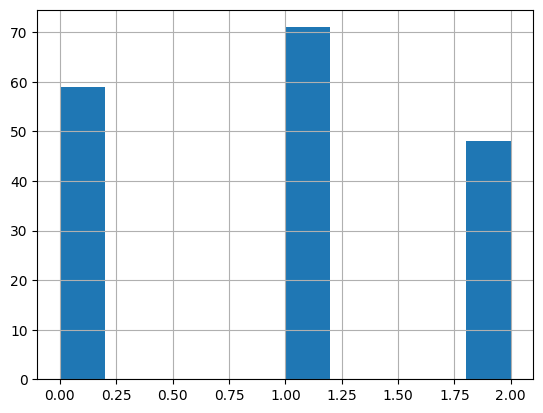

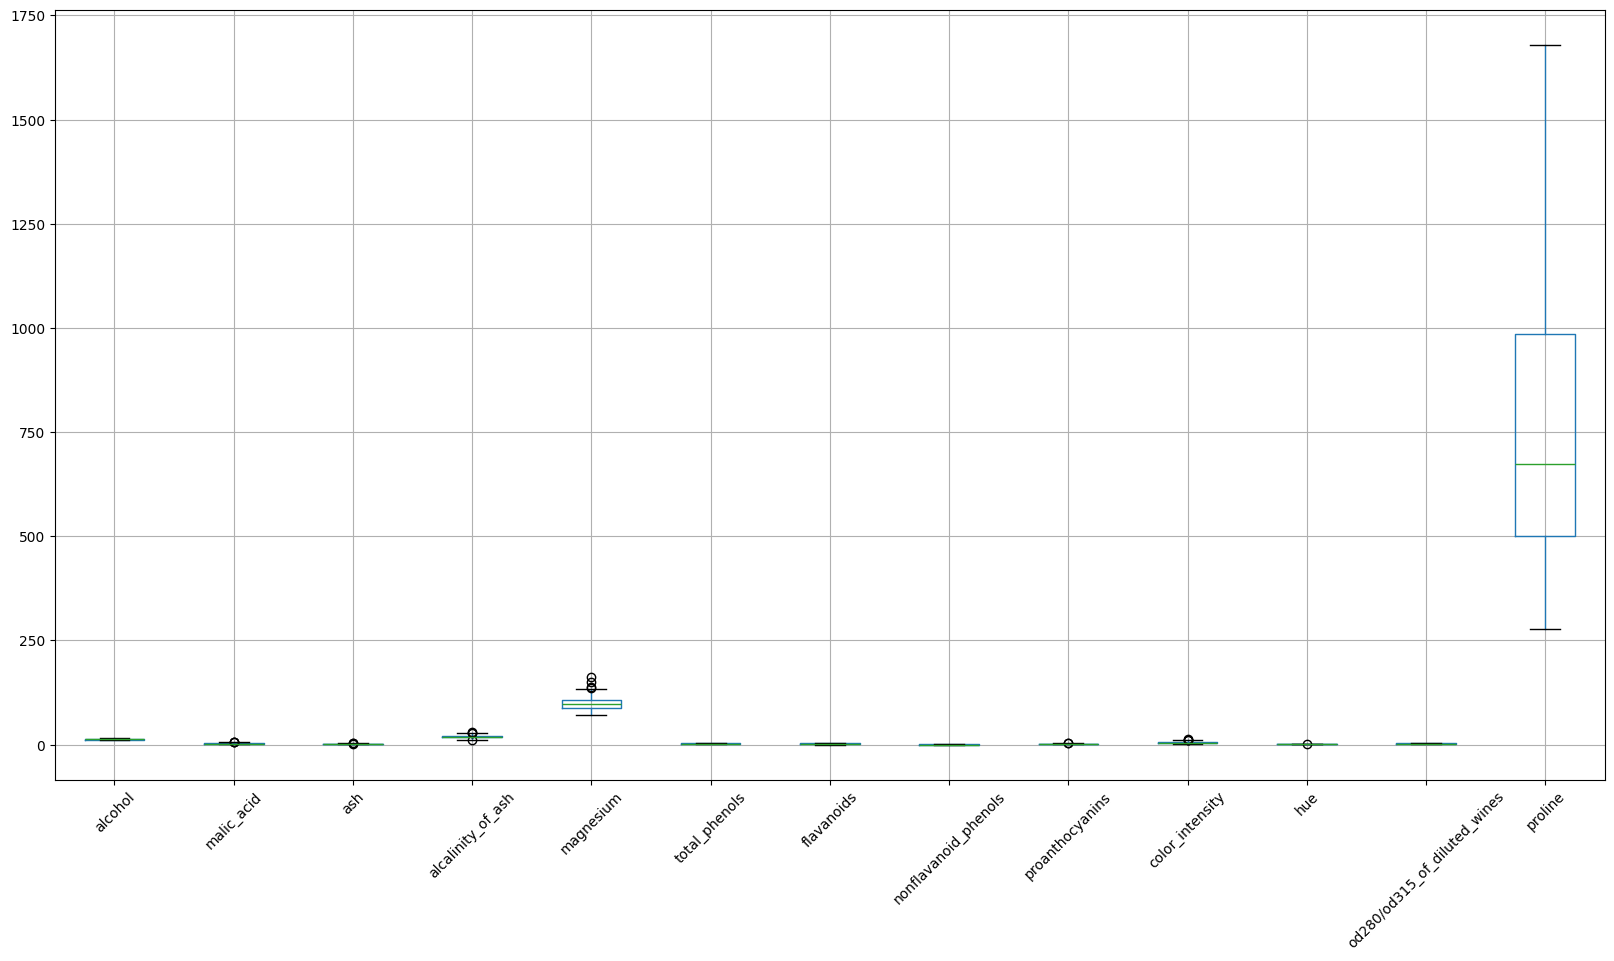

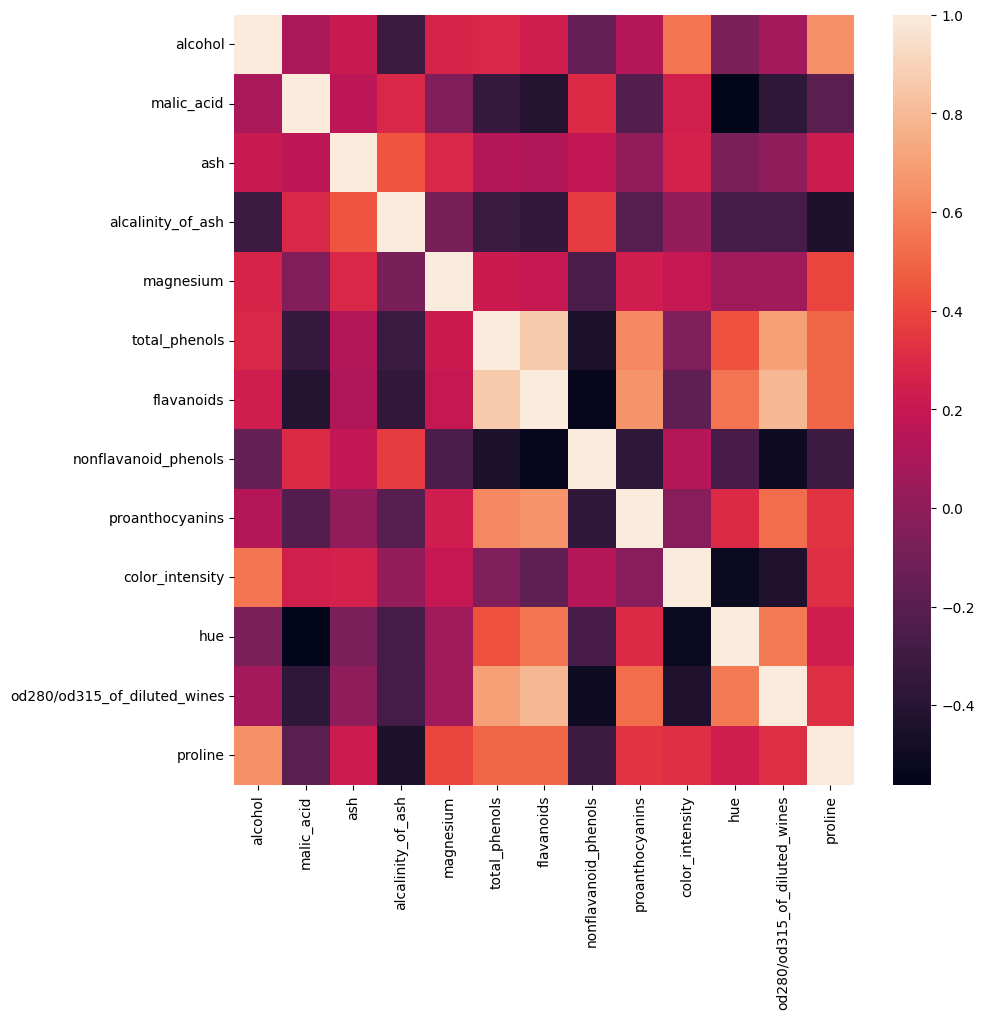

highly correlated input features:  total_phenols  &  ['flavanoids']
highly correlated input features:  flavanoids  &  ['total_phenols']
Mean Accuracy: 0.94
Mean Precision: 0.95
Mean Recall: 0.94


In [7]:
#load the wine dataset
dfX,sY = load_wine(return_X_y=True, as_frame=True)

#check the dimensions of these data
print('Dimensions of X: ',dfX.shape)
print('Dimensions of y: ',sY.shape)

#what unique classes exist in the label variable?
print('Classes in the label: ',sY.unique())

#what is the frequency of the classes in the dataset?
sY.hist()
plt.show()

#view the first 5 rows of input features
dfX.head(5)

#make a boxplot to view the distribution in these data
dfX.boxplot(figsize=(20,10),rot=45)
plt.show()

## plot the pearson correlation for our input features ##
fig, ax = plt.subplots(figsize = (10, 10))
dfCorr  = dfX.corr()
sn.heatmap(dfCorr)
plt.show()

#convert all correlations to positive values
dfCorr = dfCorr.abs()

#loop through rows
for index, sRow in dfCorr.iterrows():
    #get the valid entries
    sCorrs = sRow[sRow.index != index]
    sCorrs = sCorrs[sCorrs > 0.8]
    #print out results
    if not sCorrs.empty:
        print('highly correlated input features: ',index,' & ',sCorrs.index.values)

#create a random forest with balance class weights enabled
rfcC = RandomForestClassifierCustom(class_weights='balanced')

## train the ensemble & view estimates for prediction error ##
rfcC.fit(dfX.values,sY.values,print_metrics=False)

## use k fold cross validation to measure performance ##
scoring_metrics = {'accuracy': make_scorer(accuracy_score),
                   'precision': make_scorer(precision_score, average='weighted'),
                   'recall': make_scorer(recall_score, average='weighted')}
dcScores        = cross_validate(rfcC,dfX.values,sY.values,cv=StratifiedKFold(10),scoring=scoring_metrics)
print('Mean Accuracy: %.2f' % np.mean(dcScores['test_accuracy']))
print('Mean Precision: %.2f' % np.mean(dcScores['test_precision']))
print('Mean Recall: %.2f' % np.mean(dcScores['test_recall']))


In [8]:
## import the scikit-learn models ##
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

#create a random forest with balanced class weights
rfc = RandomForestClassifier(class_weight='balanced')

## use k fold cross validation to measure performance ##
scoring_metrics = {'accuracy': make_scorer(accuracy_score),
                   'precision': make_scorer(precision_score, average='weighted'),
                   'recall': make_scorer(recall_score, average='weighted')}
dcScores        = cross_validate(rfc,dfX.values,sY.values,cv=StratifiedKFold(10),scoring=scoring_metrics)
print('Mean Accuracy: %.2f' % np.mean(dcScores['test_accuracy']))
print('Mean Precision: %.2f' % np.mean(dcScores['test_precision']))
print('Mean Recall: %.2f' % np.mean(dcScores['test_recall']))

Mean Accuracy: 0.97
Mean Precision: 0.98
Mean Recall: 0.97


In [9]:
#Importing Libraries
import pandas as pd
import numpy as np

#Load Data
cols = ['sepal_length','sepal_width','petal_length','petal_width','Species']
df = pd.read_csv('C:/Users/Thinkpad/Documents/ml_prak/Tugas_MLprak_tm4/iris/iris.data', names=cols)
# df = df.drop("Id", axis = 1)
print(df)

#Train Test Split
train = df.sample(frac = 0.7, random_state = 1)
test = df.drop(train.index)

y_train = train["Species"]
x_train = train.drop("Species", axis = 1)

y_test = test["Species"]
x_test = test.drop("Species", axis = 1)

#Training – Count Posterior
means = train.groupby(["Species"]).mean() # Find mean of each class
var = train.groupby(["Species"]).var() # Find variance of each class
prior = (train.groupby("Species").count() / len(train)).iloc[:,1] # Find prior probability of each class
classes = np.unique(train["Species"].tolist()) # Storing all possible classes

#Classification
def Normal(n, mu, var):
    # Function to return pdf of Normal(mu, var) evaluated at x
    sd = np.sqrt(var)
    pdf = (np.e ** (-0.5 * ((n - mu)/sd) ** 2)) / (sd * np.sqrt(2 * np.pi))
    return pdf

def Predict(X):
    Predictions = []
    
    for i in X.index: # Loop through each instances
        ClassLikelihood = []
        instance = X.loc[i]
        for cls in classes: # Loop through each class
            FeatureLikelihoods = []
            FeatureLikelihoods.append(np.log(prior[cls])) # Append log prior of class 'cls'
            for col in x_train.columns: # Loop through each feature
                data = instance[col]
                mean = means[col].loc[cls] # Find the mean of column 'col' that are in class 'cls'
                variance = var[col].loc[cls] # Find the variance of column 'col' that are in class 'cls'
                Likelihood = Normal(data, mean, variance)
                if Likelihood != 0:
                    Likelihood = np.log(Likelihood) # Find the log-likelihood evaluated at x
                else:
                    Likelihood = 1/len(train) 
                
                FeatureLikelihoods.append(Likelihood)
                
            TotalLikelihood = sum(FeatureLikelihoods) # Calculate posterior
            ClassLikelihood.append(TotalLikelihood)
            
        MaxIndex = ClassLikelihood.index(max(ClassLikelihood)) # Find largest posterior position
        Prediction = classes[MaxIndex]
        Predictions.append(Prediction)     
    return Predictions

def Accuracy(y, prediction):
    # Function to calculate accuracy
    y = list(y)
    prediction = list(prediction)
    score = 0
    for i, j in zip(y, prediction):
        if i == j:
            score += 1   
    return score / len(y)

PredictTrain = Predict(x_train)
PredictTest = Predict(x_test)

print('Training Accuracy: %.4f' % round(Accuracy(y_train, PredictTrain), 5))
print('Testing Accuracy: %.4f' % round(Accuracy(y_test, PredictTest), 5))

     sepal_length  sepal_width  petal_length  petal_width         Species
0             5.1          3.5           1.4          0.2     Iris-setosa
1             4.9          3.0           1.4          0.2     Iris-setosa
2             4.7          3.2           1.3          0.2     Iris-setosa
3             4.6          3.1           1.5          0.2     Iris-setosa
4             5.0          3.6           1.4          0.2     Iris-setosa
..            ...          ...           ...          ...             ...
145           6.7          3.0           5.2          2.3  Iris-virginica
146           6.3          2.5           5.0          1.9  Iris-virginica
147           6.5          3.0           5.2          2.0  Iris-virginica
148           6.2          3.4           5.4          2.3  Iris-virginica
149           5.9          3.0           5.1          1.8  Iris-virginica

[150 rows x 5 columns]
Training Accuracy: 0.9809
Testing Accuracy: 0.9111


In [10]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(x_train, y_train)
SkTrain = clf.predict(x_train) # Predicting on the train set
SkTest = clf.predict(x_test) # Predicting on the test set

print('Training Accuracy: %.4f' % round(Accuracy(y_train, SkTrain), 5))
print('Testing Accuracy: %.4f' % round(Accuracy(y_test, SkTest), 5))


Training Accuracy: 0.9809
Testing Accuracy: 0.9111


<h2>Decision tree manual</h2>

In [19]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTree:
    def __init__(self, max_depth=100, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y):
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))

        if (depth >= self.max_depth or n_samples < self.min_samples_split or n_classes == 1):
            return Node(value=self._most_common_label(y))

        feat_idxs = np.random.choice(n_features, n_features, replace=False)
        best_feature, best_threshold = self._best_split(X, y, feat_idxs)

        left_idxs = X[:, best_feature] < best_threshold
        right_idxs = ~left_idxs

        left = self._grow_tree(X[left_idxs], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs], y[right_idxs], depth + 1)

        return Node(best_feature, best_threshold, left, right)

    def _best_split(self, X, y, feat_idxs):
        best_gain, split_idx, split_threshold = -1, None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)
                if gain > best_gain:
                    best_gain, split_idx, split_threshold = gain, feat_idx, threshold

        return split_idx, split_threshold

    def _information_gain(self, y, X_column, threshold):
        parent_entropy = self._entropy(y)
        left_idxs = X_column < threshold
        right_idxs = ~left_idxs

        if len(y[left_idxs]) == 0 or len(y[right_idxs]) == 0:
            return 0

        n = len(y)
        n_l, n_r = len(y[left_idxs]), len(y[right_idxs])
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        return parent_entropy - child_entropy

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum(np.fromiter((p * np.log2(p) for p in ps if p > 0), dtype=float))


    def _most_common_label(self, y):
        return Counter(y).most_common(1)[0][0]

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        return self._traverse_tree(x, node.left if x[node.feature] < node.threshold else node.right)

# Load and prepare the data
def load_data(file_path):
    data = pd.read_csv(file_path)
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    unique_classes = np.unique(y)
    class_to_int = {cls: i for i, cls in enumerate(unique_classes)}
    y = np.array([class_to_int[cls] for cls in y])
    return X, y

# Split the data into training and testing sets
def train_test_split(X, y, train_size=0.8):
    np.random.seed(42)
    indices = np.random.permutation(len(X))
    train_size = int(train_size * len(X))
    return X[indices[:train_size]], X[indices[train_size:]], y[indices[:train_size]], y[indices[train_size:]]

# Calculate precision and recall
def calculate_metrics(y_true, y_pred):
    classes = np.unique(y_true)
    precision = {}
    recall = {}
    accuracy = np.sum(y_pred == y_true) / len(y_true)
    for c in classes:
        true_positives = np.sum((y_pred == c) & (y_true == c))
        predicted_positives = np.sum(y_pred == c)
        actual_positives = np.sum(y_true == c)

        precision[c] = true_positives / predicted_positives if predicted_positives > 0 else 0
        recall[c] = true_positives / actual_positives if actual_positives > 0 else 0

        avg_precision = np.mean(list(precision.values()))
        avg_recall = np.mean(list(recall.values()))

    return accuracy, avg_precision, avg_recall

# Main execution
X, y = load_data('C:/Users/Thinkpad/Documents/ml_prak/Tugas_MLprak_tm6/wine_dataset.csv')
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Train the Decision Tree
model = DecisionTree()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy, average_precision, average_recall = calculate_metrics(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Average Precision: {average_precision:.4f}")
print(f"Average Recall: {average_recall:.4f}")

Accuracy: 0.8889
Average Precision: 0.9011
Average Recall: 0.8918


<h2>Decision tree sklearn</h2>

In [12]:
from sklearn.tree import DecisionTreeClassifier

dt_gini = DecisionTreeClassifier(criterion='gini', random_state=42)
dt_gini.fit(X_train, y_train)

dt_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_entropy.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [13]:
y_pred_gini = dt_gini.predict(X_test)
y_pred_entropy = dt_entropy.predict(X_test)


Metrics for Gini Model:
{'Accuracy': 0.8888888888888888, 'Precision': np.float64(0.8993055555555556), 'Sensitivity_recall': np.float64(0.8888888888888888), 'Specificity': np.float64(0.9412121212121213), 'F1_score': np.float64(0.8898148148148147)}


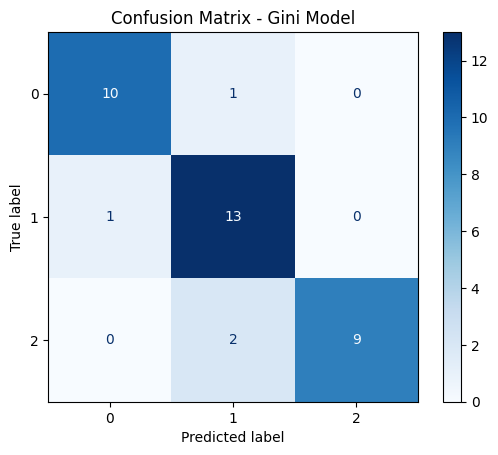


Metrics for Entropy Model:
{'Accuracy': 0.9166666666666666, 'Precision': np.float64(0.9230769230769231), 'Sensitivity_recall': np.float64(0.9166666666666666), 'Specificity': np.float64(0.9581818181818181), 'F1_score': np.float64(0.9167768959435626)}


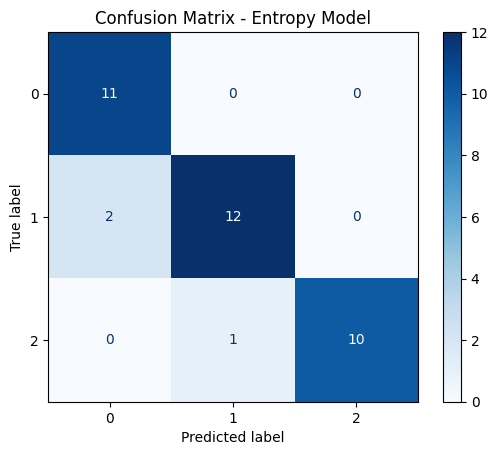

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

def calculate_and_display_metrics(observation, answer, model_name):
    # Calculate the confusion matrix
    confusion_matrix = metrics.confusion_matrix(observation, answer)
    
    # Menghitung Akurasi
    Accuracy = metrics.accuracy_score(observation, answer)
    
    # Menghitung Presisi
    Precision = metrics.precision_score(observation, answer, average='weighted')
    
    # Menghitung Sensitivitas (Recall)
    Sensitivity_recall = metrics.recall_score(observation, answer, average='weighted')
    
    # Menghitung Spesifisitas
    # Untuk multi-class, kita perlu menghitung ini secara manual
    tn = confusion_matrix.sum() - (confusion_matrix.sum(axis=0) + confusion_matrix.sum(axis=1) - np.diag(confusion_matrix))
    fp = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
    Specificity = tn / (tn + fp)
    Specificity = np.mean(Specificity)  # Rata-rata spesifisitas untuk semua kelas
    
    # Menghitung F-Score
    F1_score = metrics.f1_score(observation, answer, average='weighted')
    
    print(f"\nMetrics for {model_name}:")
    print({"Accuracy": Accuracy, "Precision": Precision, "Sensitivity_recall": Sensitivity_recall, 
           "Specificity": Specificity, "F1_score": F1_score})
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=dt_gini.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Menghitung dan menampilkan metrik untuk model Gini
calculate_and_display_metrics(y_test, y_pred_gini, "Gini Model")

# Menghitung dan menampilkan metrik untuk model Entropy
calculate_and_display_metrics(y_test, y_pred_entropy, "Entropy Model")


<h2>Naive bayes wine</h2>


Test Set Evaluation:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0
Confusion Matrix:
[[14  0  0]
 [ 0 14  0]
 [ 0  0  8]]


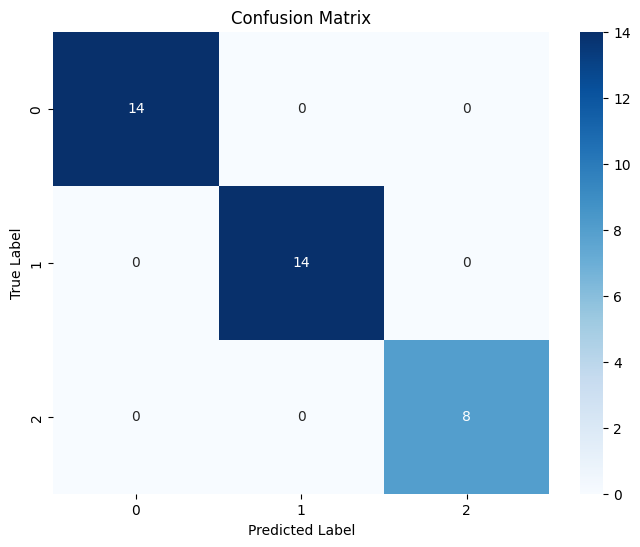

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load dataset
dfX, sY = load_wine(return_X_y=True, as_frame=True)

# Prepare the data for the decision tree
X_np = dfX.values
y_np = sY.values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2, random_state=42)

# Initialize and fit the Gaussian Naive Bayes classifier
clf = GaussianNB()
clf.fit(X_train, y_train)

# Predicting on the training set
# SkTrain = clf.predict(X_train)

# Predicting on the test set
SkTest = clf.predict(X_test)

# Evaluation metrics for the test set
accuracy_test = accuracy_score(y_test, SkTest)
precision_test = precision_score(y_test, SkTest, average='weighted')
recall_test = recall_score(y_test, SkTest, average='weighted')
f1_test = f1_score(y_test, SkTest, average='weighted')
confusion_matrix_test = confusion_matrix(y_test, SkTest)

# Print evaluation metrics for test set
print("\nTest Set Evaluation:")
print(f"Accuracy: {accuracy_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1-Score: {f1_test}")
print("Confusion Matrix:")
print(confusion_matrix_test)

# Plotting the confusion matrix using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_np), yticklabels=np.unique(y_np))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
